# Architecture and manual hyperparameters

**Tasks:**
* For this random simple task, is it better to have a wide or a deep network?
* How to make the training auto-quit when the loss doesn't decrease anymore?
* How does convergence speed early on correlate to eventual convergence?
* For later experiments, is it enough to look at initial convergence (first 10-20 epochs) or do we have to also look at network's final state (and so always wait till the full training?)
    * Answer this question above separately for things like depth and width, ...
    * And for things like regularization strength. Are the answers the same in both cases, or is it context-dependent?
    
**Main results:**
* Best architecture for this task is 32 layers → 256 layers.
* Best ADAM learning rate is 0.002 (2 times the default rate, but not more).
* First ~20 epochs are a reasonable proxy for the final optimized loss, so no need to train for longer. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

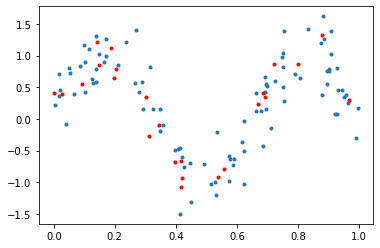

In [28]:
# Cook some simplistic data:
np.random.seed(1)
n_points = 120
x = np.random.uniform(size=n_points)
y = np.sin(x*3*np.pi) + np.random.normal(size=x.shape)/3

ind = list(range(np.round(n_points*0.2).astype(int)))
xtest = x[ind]
ytest = y[ind]
x = x[[i for i in range(n_points) if i not in ind ]]
y = y[[i for i in range(n_points) if i not in ind ]]

plt.plot(x,y,'.');
plt.plot(xtest, ytest, 'r.');

In [29]:
# Custom callback, to see what's happening during the training
# https://www.tensorflow.org/guide/keras/custom_callback

class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            print(f"{logs['loss']:0.3}", end=' ')

In [161]:
def make_model(size=None, learning_rate=0.002):
    # Let's build a model of leakyReLU units, so that we could have layer width==1, and still have gradients.
    # This woudl be useful for testing different shapes.
    # LeakyReLU cannot be set as a layer activation, it appears, but can be a separate layer.
    if size is None:
        size = (32, 32)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)), # https://www.tensorflow.org/api_docs/python/tf/keras/Input
        tf.keras.layers.Dense(size[0]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(size[1]),
        tf.keras.layers.LeakyReLU(),
        #tf.keras.layers.Dense(1),
        #tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=['mean_squared_error'])
    return model

model = make_model((8,89))
model.summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_418 (Dense)            (None, 8)                 16        
_________________________________________________________________
leaky_re_lu_242 (LeakyReLU)  (None, 8)                 0         
_________________________________________________________________
dense_419 (Dense)            (None, 89)                801       
_________________________________________________________________
leaky_re_lu_243 (LeakyReLU)  (None, 89)                0         
_________________________________________________________________
dense_420 (Dense)            (None, 1)                 90        
Total params: 907
Trainable params: 907
Non-trainable params: 0
_________________________________________________________________


0.138 0.139 0.136 0.136 0.133 0.134 0.133 0.134 0.131 0.131 0.13 0.129 0.129 0.129 0.127 0.127 0.126 0.123 0.123 0.123 0.126 0.121 0.121 0.122 0.119 0.119 0.123 0.119 0.119 0.12 0.12 0.121 0.115 0.118 0.115 

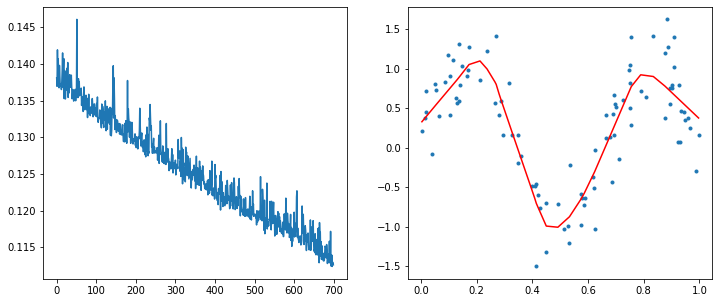

In [92]:
# Manual fit, once
history = model.fit(x, y,
                    batch_size=16,
                    epochs=700,
                    verbose=0,
                    callbacks=[CustomCallbacks()]
                    #, validation_data=(xtest, ytest) # Keeping this commented makes everything faster
                   )

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['loss']);
if 'val_loss' in history.history.keys():
    plt.plot(history.history['val_loss']);
    
plt.subplot(122)
y_new = model.predict(x)
plt.plot(x,y, '.');
ind = np.argsort(x)
plt.plot(x[ind], y_new[ind], 'r-');

In [159]:
def train_model(model, nepochs=100, verbose=False):
    """Automated trainer, reporting early slope and final loss."""
    if verbose:
        callbacks = [CustomCallbacks()]
    else:
        callbacks = []
    history = model.fit(x, y,
                    batch_size=16,
                    epochs=nepochs,
                    verbose=0,
                    callbacks=callbacks
                    #, validation_data=(xtest, ytest) # Keeping this commented makes everything faster
                   )
    loss = history.history['loss']
    return loss

train_model(model, 12)[1]

0.10631639510393143

0.02
0.01
0.005
0.002
0.001


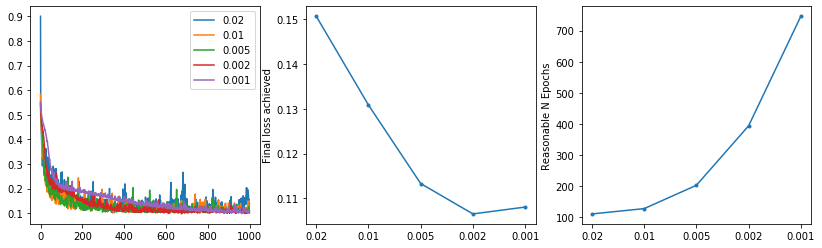

In [187]:
# Learning rate tester

options = [0.02, 0.01, 0.005, 0.002, 0.001]
final_loss = np.zeros(len(options))
good_time = np.zeros(len(options))
plt.figure(figsize=(14,4))
plt.subplot(131);
for i in range(len(options)):
    print(options[i])
    model = make_model((128,128), learning_rate=options[i])
    loss = train_model(model, 1000)
    final_loss[i] = np.mean(loss[-11:])
    good_time[i] = np.argwhere(loss <= final_loss[i])[0]
    plt.plot(loss, label=options[i]);
plt.legend();
plt.subplot(132);
plt.plot(final_loss, '.-');
plt.xticks(range(len(options)), options);
plt.ylabel('Final loss achieved');

plt.subplot(133);
plt.plot(good_time, '.-');
plt.xticks(range(len(options)), options);
plt.ylabel('Reasonable N Epochs');

**Conclusion:** For ADAM, we can go about 2 times faster (0.002) than the default rate (0.001), and also stop training ~4-5 times earlier, and still have reasonable performance. But going much faster than that makes the solution unstable.

4 4 : 
4 8 : 
4 16 : 
4 32 : 
4 64 : 
4 128 : 
4 256 : 
4 512 : 
8 4 : 
8 8 : 
8 16 : 
8 32 : 
8 64 : 
8 128 : 
8 256 : 
8 512 : 
16 4 : 
16 8 : 
16 16 : 
16 32 : 
16 64 : 
16 128 : 
16 256 : 
16 512 : 
32 4 : 
32 8 : 
32 16 : 
32 32 : 
32 64 : 
32 128 : 
32 256 : 
32 512 : 
64 4 : 
64 8 : 
64 16 : 
64 32 : 
64 64 : 
64 128 : 
64 256 : 
64 512 : 
128 4 : 
128 8 : 
128 16 : 
128 32 : 
128 64 : 
128 128 : 
128 256 : 
128 512 : 
256 4 : 
256 8 : 
256 16 : 
256 32 : 
256 64 : 
256 128 : 
256 256 : 
256 512 : 
512 4 : 
512 8 : 
512 16 : 
512 32 : 
512 64 : 
512 128 : 
512 256 : 
512 512 : 


array([[0.00787079, 0.00444289, 0.00403745, 0.00960119, 0.00689164,
        0.00571164, 0.00639772, 0.01275141],
       [0.00568931, 0.00956036, 0.00630707, 0.00713685, 0.00786308,
        0.00668944, 0.00916058, 0.01164004],
       [0.00696526, 0.0078353 , 0.00559083, 0.00458179, 0.0061111 ,
        0.00668832, 0.0108904 , 0.01514   ],
       [0.00628513, 0.00855592, 0.00813133, 0.00820011, 0.0101434 ,
        0.01126662, 0.01492473, 0.01739581],
       [0.0060758 , 0.0064047 , 0.00891517, 0.00919025, 0.01093124,
        0.01083556, 0.01404276, 0.02354969],
       [0.00779198, 0.00828369, 0.01059527, 0.00957452, 0.01371519,
        0.01846854, 0.02014709, 0.02632074],
       [0.00664259, 0.00578602, 0.01412974, 0.01494454, 0.01940939,
        0.0214902 , 0.0215432 , 0.0259052 ],
       [0.01038656, 0.01234756, 0.01992576, 0.02047533, 0.02158575,
        0.02364393, 0.02414453, 0.02304074]])

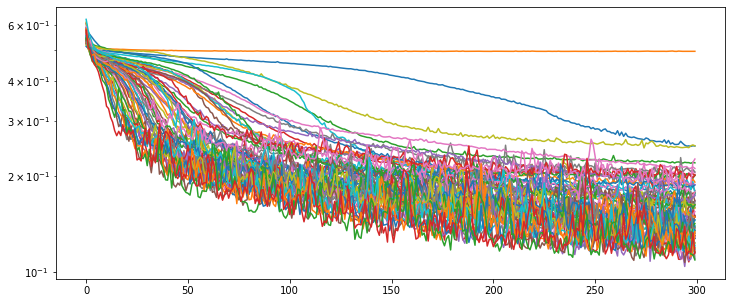

In [172]:
# Architecture search

options = [4, 8, 16, 32, 64, 128, 256, 512]
result_early = np.ones(shape=(len(options),len(options)))
result_late  = np.ones(shape=(len(options),len(options)))
plt.figure(figsize=(12,5))
plt.semilogy()
for i in range(len(options)):
    for j in range(len(options)):
        print(options[i], options[j], end=' : ')
        model = make_model((options[i], options[j]), learning_rate=0.002)
        loss = train_model(model, 300)
        result_early[i,j] = (loss[1]-loss[21])/10
        result_late[i,j] = np.mean(loss[-21:])
        plt.plot(loss)
        print()
        
result_early

In [173]:
# Save both results for posterity
def print_array(a):
    for i in range(a.shape[0]):
        print(a[i,:])
        
print_array(result_early)
print()
print_array(result_late)

[0.00787079 0.00444289 0.00403745 0.00960119 0.00689164 0.00571164
 0.00639772 0.01275141]
[0.00568931 0.00956036 0.00630707 0.00713685 0.00786308 0.00668944
 0.00916058 0.01164004]
[0.00696526 0.0078353  0.00559083 0.00458179 0.0061111  0.00668832
 0.0108904  0.01514   ]
[0.00628513 0.00855592 0.00813133 0.00820011 0.0101434  0.01126662
 0.01492473 0.01739581]
[0.0060758  0.0064047  0.00891517 0.00919025 0.01093124 0.01083556
 0.01404276 0.02354969]
[0.00779198 0.00828369 0.01059527 0.00957452 0.01371519 0.01846854
 0.02014709 0.02632074]
[0.00664259 0.00578602 0.01412974 0.01494454 0.01940939 0.0214902
 0.0215432  0.0259052 ]
[0.01038656 0.01234756 0.01992576 0.02047533 0.02158575 0.02364393
 0.02414453 0.02304074]

[0.25410884 0.49634185 0.22158415 0.20301366 0.16404304 0.15123507
 0.2049938  0.19228125]
[0.2486028  0.16428786 0.17740255 0.19074262 0.20116069 0.16937275
 0.1463453  0.1746562 ]
[0.21453773 0.20921718 0.15987787 0.18410309 0.18743213 0.15278675
 0.17483017 0.14691898]

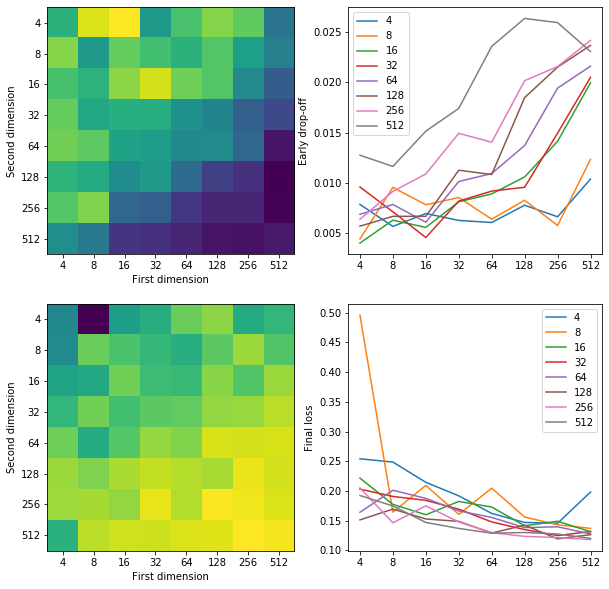

In [174]:
# Visualize results
plt.figure(figsize=(10,10));
plt.subplot(221);
plt.imshow(-np.log(result_early));
plt.xticks(range(len(options)), options);
plt.yticks(range(len(options)), options);
plt.xlabel('First dimension');
plt.ylabel('Second dimension');

plt.subplot(222);
plt.plot(result_early);
plt.xticks(range(len(options)), options);
plt.ylabel('Early drop-off');
plt.legend(labels=options);

plt.subplot(223);
plt.imshow(-np.log(result_late));
plt.xticks(range(len(options)), options);
plt.yticks(range(len(options)), options);
plt.xlabel('First dimension');
plt.ylabel('Second dimension');

plt.subplot(224);
plt.plot(result_late);
plt.xticks(range(len(options)), options);
plt.ylabel('Final loss');
plt.legend(labels=options);

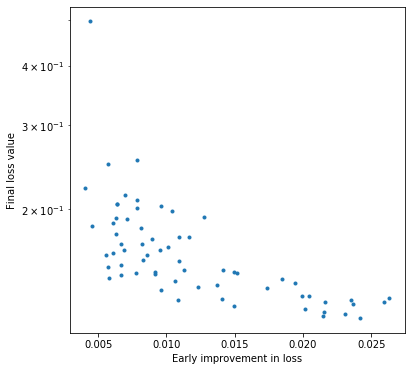

In [180]:
# Compare early drop-off rate to final state

plt.figure(figsize=(6,6))
plt.plot(result_early.flatten(), result_late.flatten(), '.');
plt.xlabel('Early improvement in loss');
plt.ylabel('Final loss value');
plt.semilogy();

**Conclusion**: Early drop is actually a reasonable predictor of the final state (surprisingly!), even if the loss function goes through a plato (here I looked at loss after 20 epochs, while the plato was over at about 75 epochs). Presumably that's because the presence of a plato is a property of the data, and not of the model.

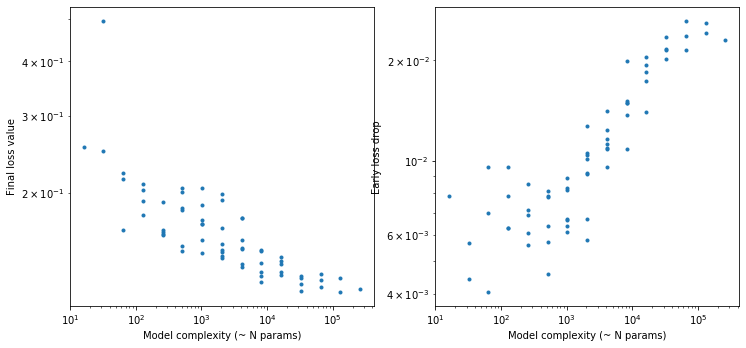

In [186]:
# Total model complexity
complexity = np.outer(options, options)
plt.figure(figsize=(12,5.5))
plt.subplot(121);
plt.plot(complexity.flatten(), result_late.flatten(), '.');
plt.xlabel('Model complexity (~ N params)');
plt.ylabel('Final loss value');
plt.loglog();

plt.subplot(122);
plt.plot(complexity.flatten(), result_early.flatten(), '.');
plt.xlabel('Model complexity (~ N params)');
plt.ylabel('Early loss drop');
plt.loglog();

**Conclusion:** While obviously a larger model is better, in this case a slightly flaring setup (128→256) was actually as good as (512→512), or (256→512). Or better! Yet it's 8 times fewer parameters.

And note, it's flaring, not converging! Which is prob because we need to draw something instead of funneling info into a classifier, but the point is, the optimal architecture is context-dependent.

Note also that (32→256), which is a 32 times economy in N-params, is almost as good as the best one.